# Inferring age structured parameters for SARS-2 transmission
Sam Brand *et al*

In this note I'm analysing the data available from the CPERE report *The epidemiological characteristics of an outbreak of 2019 novel coronavirus diseases (COVID-19) in China, 2020*, which included the ~44k confirmed cases in China up until the 11th Feburary. I'm using Hamiltonian MCMC to fit age-dependent rates of becoming a clinical case after infection with SARS-CoV-2

Key points about usage of the data:

* The data is in 10 yearly blocks ending in a 80+ age category (9 categories). However, the age mixing matrix from Prem *et al* (Prem, K., Cook, A. R. & Jit, M. Projecting social contact matrices in 152 countries using contact surveys and demographic data. PLoS Comput Biol 13, e1005697–21 (2017).) is in 5 yearly blocks ending in a 75+ age category (16 categories). I extend the Prem *et al* age mixing matrix to a 17 group matrix by assuming: (i) that 75-79 and 80+ year olds meet other age groups at the same rate as 75+ year olds, and, (ii) other age groups meeting any 75+ year old distribute their contacts between 75-79 year olds and 80+ year old proportionately to population size.
* The Prem *et al* study breaks contacts down by situation: School, work, home and other. We have assumed that the appropriate mixing matrix for China is the "home-only" version, this reflects that severe social distancing measures were in place for the majority of this period.


### SARS-CoV-2 transmission model with symptomatic and asymptomatic infections (model 1), its next generation matrix and the likelihood
In this note, I'm focused on the expected distribution of cases amongst age groups and fitting this to available case data. Infected individuals are either eventually detected, because of symptoms (very few asymptomatic detections at this stage, and these were not included in the data I use here), or undetected. After their latency period infecteds either become "symptomatic/eventually detected" with probability age-dependent probability $d_a$, or become "asymptomatic/never detected" with probability $1-d_a$. I assume that detected/symptomatic individuals infect on average $R$ other individuals, and undetected/asymptomatic individuals infected on average $\epsilon R$ other individuals. The next generation matrix $K_{ab}$, the number of $a$ group individuals infected on average per $b$ group infected, is,

\begin{equation}
    K_{ab} = R \kappa_{ab} (d_b + \epsilon (1-d_b)).
\end{equation}

Where $\kappa_{ab}$ is the distribution of contacts to the $a$ group from a typical $b$ group individual. $R_0$ is the leading eigenvalue of $K$, the effective reproductive number during the Chinese epidemic. The effective $R_0$ for China varied with time, according to multiple studies. However, the *case distribution*, $C_a$, the proportion of cases in each age group would be constant in time so long as $\kappa$, and $d_a$ are fixed. This is a potential source of error because I didn't manage to exclude the early cases from the CCDC report. $C_a$ is the leading eigenvector of $K$. The inference problem is under-specified, therefore we considered 5 possibilities: $\tau = 0., 0.1, 0.25, 0.5, 1$, and fixed $d_{80+} = 1$, therefore giving other $d_a$ values as relative to this.

The likelihood for the model comes from calculating $C_a$ for the target parameters, then assuming independent multinomial selection of cases for the dataset.

In [1]:
using TransformVariables, LogDensityProblems, DynamicHMC, DynamicHMC.Diagnostics, Distributions,MAT,Plots,StatsPlots
using MCMCDiagnostics, LinearAlgebra
using Parameters, Statistics, Random
import ForwardDiff
using CSV,DataFrames,JLD2

┌ Info: Precompiling TransformVariables [84d833dd-6860-57f9-a1a7-6da5db126cff]
└ @ Base loading.jl:1273
┌ Info: Precompiling LogDensityProblems [6fdf6af0-433a-55f7-b3ed-c6c6e0b8df7c]
└ @ Base loading.jl:1273
┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1273
┌ Info: Precompiling DynamicHMC [bbc10e6e-7c05-544b-b16e-64fede858acb]
└ @ Base loading.jl:1273
┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1273
┌ Info: Precompiling MAT [23992714-dd62-5051-b70f-ba57cb901cac]
└ @ Base loading.jl:1273
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** inc

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Info: Precompiling MCMCDiagnostics [6e857e4b-079a-58c4-aeab-bc2670384359]
└ @ Base loading.jl:1273
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1273
┌ Info: Precompiling JLD2 [033835bb-8acc-5ee8-8aae-3f567f8a3819]
└ @ Base loading.jl:1273


Loading relevant data, and converting the contact matrix (which is plotted) as explained above.

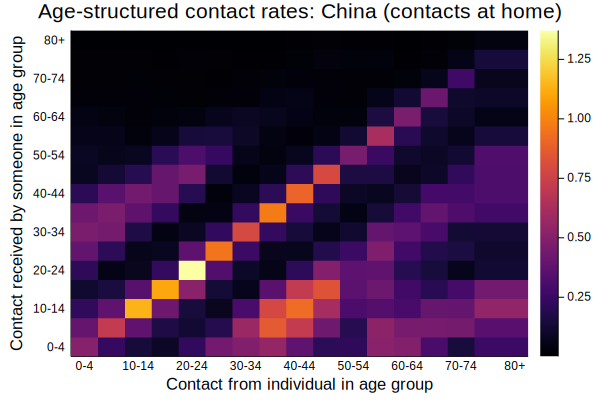

In [2]:
#Home-setting age-structured contact matrix from Prem et al
file = matopen("China_Mixing_ho.mat")
China_Mixing_ho = read(file, "China_Mixing_ho")
close(file)
#CCDC case data for confirmed cases broken down by age
file = matopen("CCDC_Case_Dist_Feb_11.mat")
CCDC_Case_Dist_Feb_11 = read(file, "CCDC_Case_Dist_11_feb")
close(file)
#Chinese population pyramid
file = matopen("Pop_Pyramids.mat")
China_PP = read(file, "China_PP")
close(file)
#Group the population pyramid according to the CCDC report age groups
_China_PP = zeros(9)
for i = 1:8
    _China_PP[i] = China_PP[2*(i-1)+ 1] + China_PP[2*(i-1)+ 2]
end
_China_PP[9] = sum(China_PP[19:end])
LinearAlgebra.normalize!(_China_PP,1);

age_cats = ["0-4","5-9","10-14","15-19","20-24","25-29","30-34","35-39",
            "40-44","45-49","50-54","55-59","60-64","65-69","70-74","75-79","80+"];

#Extend the Prem contact matrix as described above
China_from_to = zeros(17,17);
ratio = China_PP[19]/sum(China_PP[19:end])
for i = 1:16,j=1:15
    China_from_to[i,j] = China_Mixing_ho[i,j]
end
for i = 1:16
    China_from_to[i,16] = China_Mixing_ho[i,16]*ratio
    China_from_to[i,17] = China_Mixing_ho[i,16]*(1-ratio)
end
for j = 1:17
    China_from_to[17,j] = China_from_to[16,j]
end
China_to_from = Matrix(China_from_to')

#Method for converting from the 17 5-yearly age groups to the 9 10-yearly age groups in the data
function convert_to_data_agegroups(v)
    _v = zeros(9)
    for i = 1:8
        _v[i] = v[2*(i-1)+1] + v[2*(i-1)+2]
    end
    _v[9] = v[17]
    return LinearAlgebra.normalize!(_v,1)
end
plt_heatmap = heatmap(China_from_to',xticks=(1:2:17,age_cats[1:2:17]),yticks=(1:2:17,age_cats[1:2:17]),
                    title = "Age-structured contact rates: China (contacts at home)",
                    xlabel = "Contact from individual in age group",
                    ylabel = "Contact received by someone in age group ")
# savefig(plt_heatmap,"China_home_only.pdf")

If the detection/symptomatic rate was age-independent then the case distribution is just the leading eigenvector of the contact matrix (normalized to sum to 1). We plot a comparison between: (i) the population pyramid of China, (ii) the age-independent case distribution, and (iii) the age distribution of confirmed cases.

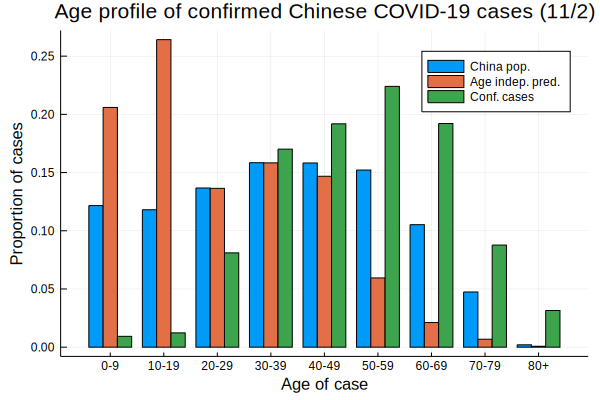

In [3]:
#Calculate eigenvalues and eigenvectors of the contact matrix. The (L_1) normalised leading eigenvector 
#is the case distribution **if**
evals,evects = eigen(China_to_from);

R₀ = Real(evals[end])
v = Real.(evects[:,end])
_v = convert_to_data_agegroups(v)

Case_Dist = LinearAlgebra.normalize(CCDC_Case_Dist_Feb_11[:],1)


plt = groupedbar(hcat(_China_PP,_v,Case_Dist),lab = ["China pop." "Age indep. pred." "Conf. cases"],
        xticks=(1:9,["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80+"]),
        title = "Age profile of confirmed Chinese COVID-19 cases (11/2)",
        ylabel = "Proportion of cases",
        xlabel = "Age of case")
# savefig(plt,"age_profile_cases.pdf")

Note that both a uniform attack rate, or an attack rate based only on social contacts, seems to explain the case distribution.

## Fitting using DynamicHMC.jl

I am fitting using Hamiltonian MCMC (HMC), the reason for choosing this is that HMC has good theoretical properties when inferring joint posterior distributions for > ~5 parameters because it investigates the "typical set" of the posterior distribution efficiently (c.f. *Betancourt, M. A Conceptual Introduction to Hamiltonian Monte Carlo. arXiv.org stat.ME, (2017).*). 

The HMC method I am using is the NUTS algorithm implemented in the **DynamicHMC.jl** package.

The pattern for using **DynamicHMC** is to:
1. Define your data as a struct.
2. Define a struct function which evaluates the posterior likelihood of any parameter set.
3. Define a transformation on the parameters (in this case I transform so that they are always non-negative).
4. Define a method for automatic differention (I use ForwardDiff, a Forward-mode AD package)

I calculate the expected case distribution for the parameters use a 10-generation recursion through the next-generation matrix. The reason for this is that solving for the leading eigenvector is not automatically differentiable because of the iterative methods used in numerical eigenvector solvers. I've checked that this method is accurate using recursive randomly chosen parameters (not shown here).

In [4]:
#Function for calculating the case distribution (NB: σ is the age-dependent susceptibility; in Feb it was not clear
#whether age-distribution of cases was due to greater resistance amongst younger age groups. This now seems unlikely and
#σ_a = 1 for each a in this note.
function pred_case_distribution_using_iter_K(χ::Vector,d::Vector,ϵ::Vector,C)
    d1, = size(C)
    T = eltype(d)
    K = zeros(T,d1,d1)
    for a = 1:d1,b=1:d1
        K[a,b] = χ[a]*C[a,b]*(d[a] + (1-d[b])*ϵ[b])
    end
    v = (K^10)*ones(d1)
    
    return d.*v/sum(d.*v)
end

#This is a struct for the case data in numbers rather than proportions
struct CaseDistribution
    C::Vector{Int64} #Total number of cases in each age group
    n::Int64 #Total number of cases
    prediction::Function #This is the function that makes a prediction about case distribution
end


#This is the log-likelihood function (a callable function on CaseDistribution structs). Its an unnormalised
#independent multinomial likelihood
function (cases::CaseDistribution)(θ) #Susceptibility form of likelihood
    @unpack θ = θ               # extract the parameters θ is a generic label for any set of params, the difference is in the prediction function
    @unpack n, C, prediction = cases   # extract the data and prediction function
    T = eltype(θ)
    p = prediction(θ) #predicted distribution of cases
    try 
        logL = 0.
        for i = 1:8
            logL += C[i]*log(p[2*(i-1)+1] + p[2*(i-1)+2])
        end
        logL += C[9]*log(p[17]) 
        return logL  - 200*(θ[17] - 1)^2 #Prior the last sigma to tether the posterior distribution to a choice
    catch errtype
        return T(-Inf)
    end
        
end




## Fitting for $\epsilon = 0,0.1,0.25,0.5,1$ for model 1
A detailed progress report from the HMC/NUTS sampler which details the initial optimisation of starting point, and repeated optimisation of step-size and kinetic energy for the proposal step can be accessed by removing the *NoProgressReport* bit.

In [ ]:
cases_fit_d_epsilon_0 = CaseDistribution(Int64.(CCDC_Case_Dist_Feb_11[:]),
                    Int64(sum(CCDC_Case_Dist_Feb_11)),
                    d -> pred_case_distribution_using_iter_K(ones(17),d,zeros(17),China_to_from))


trans = as((θ = as(Array, asℝ₊, 17),)) # All parameters are transformed to be positive.
P = TransformedLogDensity(trans, cases_fit_d_epsilon_0) #This creates a transformed log-likelihood
∇P = ADgradient(:ForwardDiff, P) #This automatically generates a log-likelihood gradient at the same time as the likelihood is called
results_d_epsilon_0 = mcmc_with_warmup(Random.GLOBAL_RNG, ∇P, 10000,reporter = NoProgressReport());

In [5]:
cases_fit_d_epsilon_01 = CaseDistribution(Int64.(CCDC_Case_Dist_Feb_11[:]),
                    Int64(sum(CCDC_Case_Dist_Feb_11)),
                    d -> pred_case_distribution_using_iter_K(ones(17),d,0.1*ones(17),China_to_from))


trans = as((θ = as(Array, asℝ₊, 17),))#Transforms the relative values into definitely positive numbers 16th value is fixed as 1
P = TransformedLogDensity(trans, cases_fit_d_epsilon_01)
∇P = ADgradient(:ForwardDiff, P)
results_d_epsilon_01 = mcmc_with_warmup(Random.GLOBAL_RNG, ∇P, 10000,reporter = NoProgressReport());

┌ Info: finding initial optimum
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:71
┌ Info: found initial stepsize
│   ϵ = 0.0103
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:71
┌ Info: Starting MCMC
│   total_steps = 75
│   tuning = stepsize
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:102
┌ Info: MCMC progress
│   step = 1
│   seconds_per_step = 0.0047
│   estimated_seconds_left = 0.35
│   ϵ = 0.0103
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120


InterruptException: InterruptException:

In [16]:
cases_fit_d_epsilon_025 = CaseDistribution(Int64.(CCDC_Case_Dist_Feb_11[:]),
                    Int64(sum(CCDC_Case_Dist_Feb_11)),
                    d -> pred_case_distribution_using_iter_K(ones(17),d,0.25*ones(17),China_to_from))


trans = as((θ = as(Array, asℝ₊, 17),))#Transforms the relative values into definitely positive numbers 16th value is fixed as 1
P = TransformedLogDensity(trans, cases_fit_d_epsilon_025)
∇P = ADgradient(:ForwardDiff, P)
results_d_epsilon_025 = mcmc_with_warmup(Random.GLOBAL_RNG, ∇P, 10000,reporter = NoProgressReport());

In [17]:
cases_fit_d_epsilon_05 = CaseDistribution(Int64.(CCDC_Case_Dist_Feb_11[:]),
                    Int64(sum(CCDC_Case_Dist_Feb_11)),
                    d -> pred_case_distribution_using_iter_K(ones(17),d,0.5*ones(17),China_to_from))


trans = as((θ = as(Array, asℝ₊, 17),))#Transforms the relative values into definitely positive numbers 16th value is fixed as 1
P = TransformedLogDensity(trans, cases_fit_d_epsilon_05)
∇P = ADgradient(:ForwardDiff, P)
results_d_epsilon_05 = mcmc_with_warmup(Random.GLOBAL_RNG, ∇P, 10000,reporter = NoProgressReport());

In [18]:
cases_fit_d_epsilon_1 = CaseDistribution(Int64.(CCDC_Case_Dist_Feb_11[:]),
                    Int64(sum(CCDC_Case_Dist_Feb_11)),
                    d -> pred_case_distribution_using_iter_K(ones(17),d,ones(17),China_to_from))


trans = as((θ = as(Array, asℝ₊, 17),))#Transforms the relative values into definitely positive numbers 16th value is fixed as 1
P = TransformedLogDensity(trans, cases_fit_d_epsilon_1)
∇P = ADgradient(:ForwardDiff, P)
results_d_epsilon_1 = mcmc_with_warmup(Random.GLOBAL_RNG, ∇P, 10000,reporter = NoProgressReport());

In [19]:
#Save the MCMC results 
using JLD2

@save "MCMC_results_fit_d.jld2" results_d_tau_0 results_d_tau_01 results_d_tau_025 results_d_tau_05 results_d_tau_1


## Analysing the results

Rather than re-run the above... here are some I made earlier!

In [37]:
using JLD2
@load "MCMC_results_fit_d.jld2" results_d_tau_0 results_d_tau_01 results_d_tau_025 results_d_tau_05 results_d_tau_1
trans = as((θ = as(Array, asℝ₊, 17),)); #Posterior draws are saved in transformed state, trans is used to convert back to untransformed draws.

### Diagnostics
First, I look at the NUTS-specific tree statistics. The point of HMC/NUTS is to generate efficient proposals and minimise wasteful "U-turns" where proposals return frequently to already sampled regions of parameter space. Acceptance rate was greater than 88% in each scenario (run the code block below for each set of results).

In [42]:
summarize_tree_statistics(results_d_tau_1.tree_statistics)

Hamiltonian Monte Carlo sample of length 10000
  acceptance rate mean: 0.92, 5/25/50/75/95%: 0.74 0.88 0.95 0.98 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 0%, 5 => 0%, 6 => 0%, 7 => 2%, 8 => 28%, 9 => 70%, 10 => 0%

Second, the effective sample size. We've applied the *effective_sample_size* (from MCMCDiagnostics.jl) to each age group (0-4,5-9,...) and each scenario ($\tau = 0, 0.1,...$). The eff. sample size is always above 3,000 and only two age/scenario parameters have an eff. sample size of less than 5000.

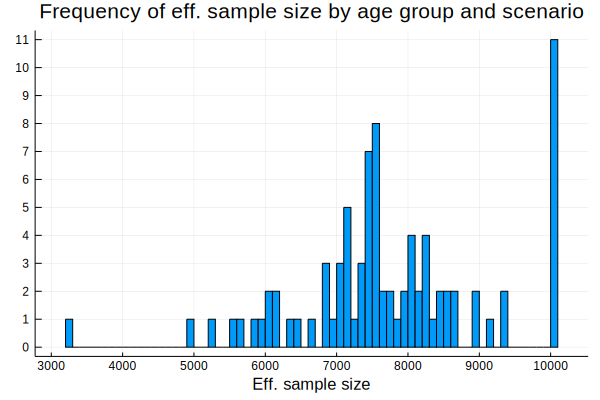

In [55]:
#Group results
results_group = [results_d_tau_0,results_d_tau_01,results_d_tau_025,results_d_tau_05,results_d_tau_1];
eff_sample_sizes = Float64[]
for result in results_group
    posterior = first.(transform.(trans, result.chain)) #Apply transformation to chain
    for a = 1:17 
        posterior_samples_for_group_a = [posterior[i][a] for i = 1:length(posterior)]
    push!(eff_sample_sizes,effective_sample_size(posterior_samples_for_group_a)   )
    end
end

histogram(eff_sample_sizes,bins = 100,lab = "",xlabel = "Eff. sample size",
            title = "Frequency of eff. sample size by age group and scenario",
            xticks = (3000:1000:10000),yticks = 0:1:15)

We can also look at a direct comparison of the data and the posterior prediction. Unsurprisingly, due to the under-specified nature of the problem the fits are essentially exact.

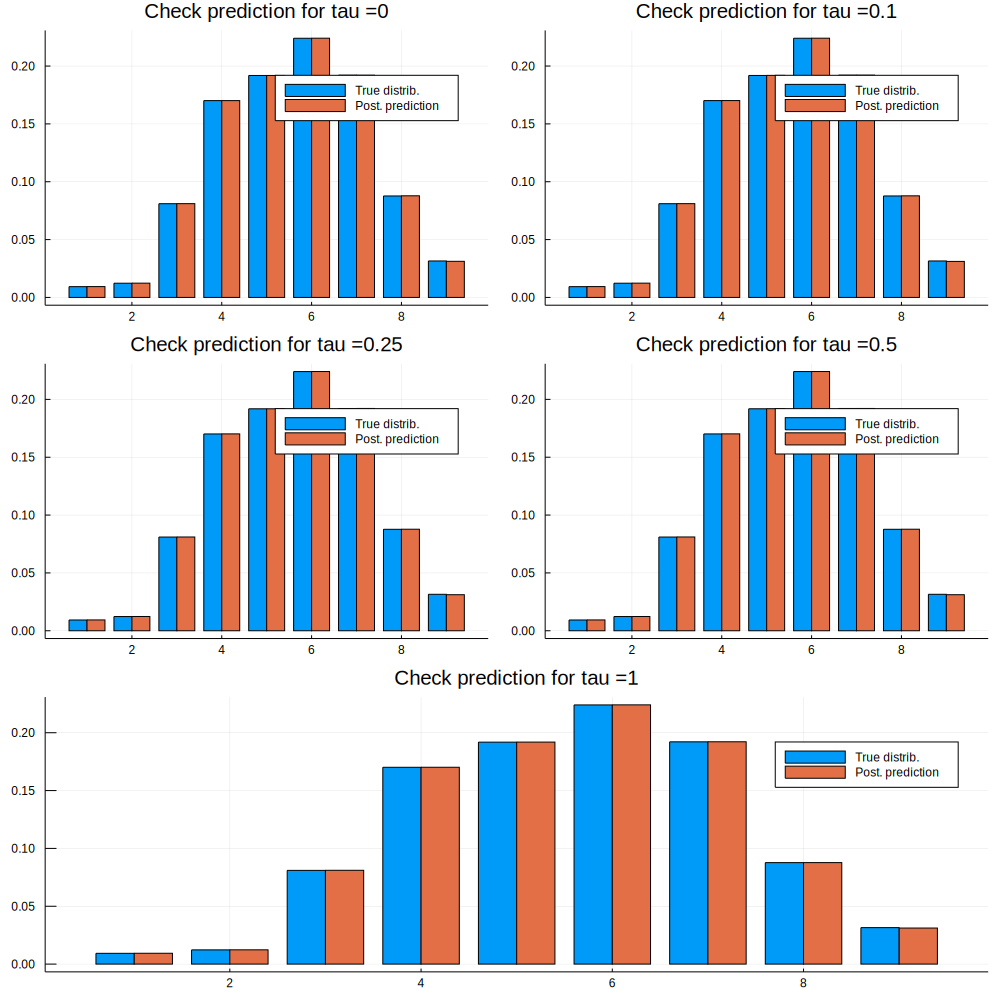

In [78]:
function posterior_prediction(result,tau)
    posterior = first.(transform.(trans, result.chain))
    pred = map(d -> pred_case_distribution_using_iter_K(ones(17),d,tau*ones(17),China_to_from),posterior);
    _pred = map(convert_to_data_agegroups,pred)
    return groupedbar(hcat(Case_Dist,mean(_pred)),lab = ["True distrib." "Post. prediction"],title = "Check prediction for tau =$tau")
end
# plt_pred_05 = groupedbar(hcat(Case_Dist,mean(_pred)),lab = ["True distrib." "Post. prediction"],title = "Check prediction for tau =0.25")
plt1 = posterior_prediction(results_d_tau_0,0);
plt2 = posterior_prediction(results_d_tau_01,0.1);
plt3 = posterior_prediction(results_d_tau_025,0.25);
plt4 = posterior_prediction(results_d_tau_05,0.5);
plt5 = posterior_prediction(results_d_tau_1,1);

layout = @layout [a b;c d;e]
plt = plot(plt1,plt2,plt3,plt4,plt5,layout = layout)
plot!(plt,size = (1000,1000))


### Posterior distribution --- Model 1
The posterior distribution plotted for each scenario as posterior mean with 95% credible intervals.

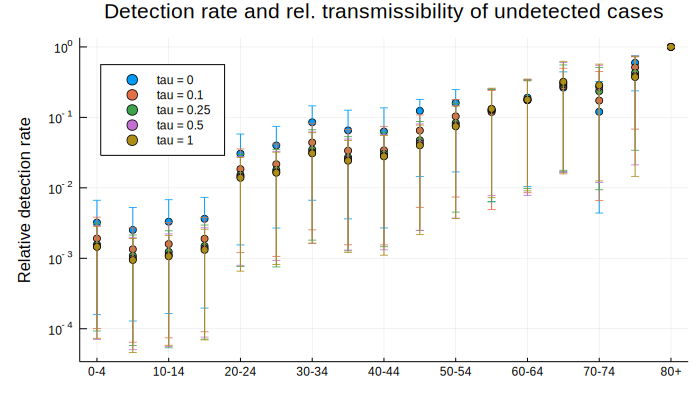

In [79]:
function MCMCchain2estimates(results)
    posterior = first.(transform.(trans, results.chain))
    posterior_array = zeros(length(posterior),17)
    for i = 1:length(posterior),j=1:17
        posterior_array[i,j] = posterior[i][j]
    end
    for i = 1:length(posterior),j=1:17
        posterior_array[i,j] = posterior_array[i,j]/posterior_array[i,17] #Renormalise d_80+ to 1 and other values to relative to this
    end    
    θ̂ = [mean(posterior_array[:,i]) for i = 1:17]
    lb = [quantile(posterior_array[:,i],0.025) for i = 1:17]
    ub = [quantile(posterior_array[:,i],0.975) for i = 1:17]
    return θ̂,θ̂ .- lb,ub.-θ̂
end

d_0,lb_0,ub_0 = MCMCchain2estimates(results_d_tau_0)
d_01,lb_01,ub_01 = MCMCchain2estimates(results_d_tau_01)
d_025,lb_025,ub_025 = MCMCchain2estimates(results_d_tau_025)
d_05,lb_05,ub_05 = MCMCchain2estimates(results_d_tau_05)
d_1,lb_1,ub_1 = MCMCchain2estimates(results_d_tau_1)


fig_d = scatter(d_0,yerr = (lb_0,ub_0),fillalpha = 0.3,lab="tau = 0",legend = :topleft,
        xticks = (1:2:17,["0-4","10-14","20-24","30-34","40-44","50-54","60-64","70-74","80+"]),
        ylabel = "Relative detection rate", title = "Detection rate and rel. transmissibility of undetected cases",
        yscale = :log10)
scatter!(fig_d,d_01,yerr = (lb_01,ub_01),fillalpha = 0.3,lab="tau = 0.1")
scatter!(fig_d,d_025,yerr = (lb_025,ub_025),fillalpha = 0.3,lab="tau = 0.25")
scatter!(fig_d,d_05,yerr = (lb_05,ub_05),fillalpha = 0.3,lab="tau = 0.5")
scatter!(fig_d,d_1,yerr = (lb_1,ub_1),fillalpha = 0.3,lab="tau = 1")
scatter!(size=(700,400))


# savefig(fig_d,"detection_and_rel_trans.pdf")
#Save the posterior means for the detection/symptomatic rates by age
# @save "detection_rates_for_different_taus.jld2" d_0 d_01 d_025 d_05 d_1

## SARS-CoV-2 transmission model with Pre-symptomatic (P), asymptomatic (A), mild (M) and eventually severe infections (V) (model 2)

We use recent data on the relative susceptibility of younger and older age groups (*Zhang, J. et al. Changes in contact patterns shape the dynamics of the COVID-19 outbreak in China. Science 2, eabb8001–13 (2020).*) to refit the symptomatic rates.

The next generation matrix for model 2 is 
\begin{equation}
    K_{ab} = \chi_a  \kappa_{ab} \Big({\epsilon\over\sigma_2} + (1-d_b) R_A + d_b(1-h_b) R_M +  d_b h_b R_V \Big).
\end{equation}


In [5]:
#Modified prediction function --- this assumes mean 2 days of pre-symptomatic transmission, mean 7 days infectious period for
#mild infecteds and that the eventually severe cases don't transmit more than mild cases

function pred_case_distribution_using_iter_K_model2(χ::Vector,d::Vector,ϵ::Vector,C)
    d1, = size(C)
    K = zeros(eltype(d),d1,d1)
    for a = 1:d1,b=1:d1
        K[a,b] = χ[a]*C[a,b]*(2*ϵ[b] + 7*d[b] + 7*(1-d[b])*ϵ[b])
    end
    v = (K^10)*ones(d1)
    
    return d.*v/sum(d.*v)
end

#This function returns the HMC chains with tree statistics for the run
function HMC_for_detection_rate(χ,ϵ,n_draws)
    cases_to_fit = CaseDistribution(Int64.(CCDC_Case_Dist_Feb_11[:]),
                        Int64(sum(CCDC_Case_Dist_Feb_11)),
                        d -> pred_case_distribution_using_iter_K_model2(χ,d,ϵ*ones(17),China_to_from))

    trans = as((θ = as(Array, asℝ₊, 17),)) # All parameters are transformed to be positive.
    P = TransformedLogDensity(trans, cases_to_fit) #This creates a transformed log-likelihood
    ∇P = ADgradient(:ForwardDiff, P) #This automatically generates a log-likelihood gradient at the same time as the likelihood is called
    return results = mcmc_with_warmup(Random.GLOBAL_RNG, ∇P, n_draws,reporter = NoProgressReport())
end


HMC_for_detection_rate (generic function with 1 method)

In [6]:
χ_zhang = vcat(0.34*ones(3),ones(10),1.47*ones(4))

17-element Array{Float64,1}:
 0.34
 0.34
 0.34
 1.0 
 1.0 
 1.0 
 1.0 
 1.0 
 1.0 
 1.0 
 1.0 
 1.0 
 1.0 
 1.47
 1.47
 1.47
 1.47

In [7]:
d_chain_model2_epsilon_0 = HMC_for_detection_rate(χ_zhang,0.,10000)
d_chain_model2_epsilon_01 = HMC_for_detection_rate(χ_zhang,0.1,10000)
d_chain_model2_epsilon_025 = HMC_for_detection_rate(χ_zhang,0.25,10000)
d_chain_model2_epsilon_05 = HMC_for_detection_rate(χ_zhang,0.5,10000)
d_chain_model2_epsilon_1 = HMC_for_detection_rate(χ_zhang,1.,10000)

(chain = Array{Float64,1}[[-4.706789474867995, -5.448645005157384, -4.77186190740604, -6.9122399313469725, -3.471768127298153, -5.207869770128656, -2.5931845256906327, -3.1631540482921965, -3.334834402962016, -2.655156796117433, -1.896665031951241, -2.407818716246434, -0.7886288479617438, -2.2006115604200334, -0.5164050045667083, -5.007559819250971, 0.029035286449639652], [-4.8472809265150065, -5.183541137540748, -6.9283262728546005, -5.653089413160438, -3.5925013384334115, -4.486297703601706, -2.738538744626581, -2.986006940619077, -2.7488558131137566, -3.1939349991263786, -3.9538026970480806, -1.0772059375785552, -2.7366102530516163, -0.5922843815867759, -0.536053894246115, -3.3466182129748394, -0.027025603755926365], [-6.218827311370969, -4.549742324183914, -4.947021350115141, -6.455051787893755, -3.6873157363548232, -3.9901665597337574, -2.0654963386479293, -4.603396246074638, -2.7388348924376515, -3.062020450958455, -4.1018305900452985, -1.0095408296914445, -3.370413838399557, -0.

In [8]:
@save "HMC_chains_for_model2.jld2" d_chain_model2_epsilon_0 d_chain_model2_epsilon_01 d_chain_model2_epsilon_025 d_chain_model2_epsilon_05 d_chain_model2_epsilon_1  

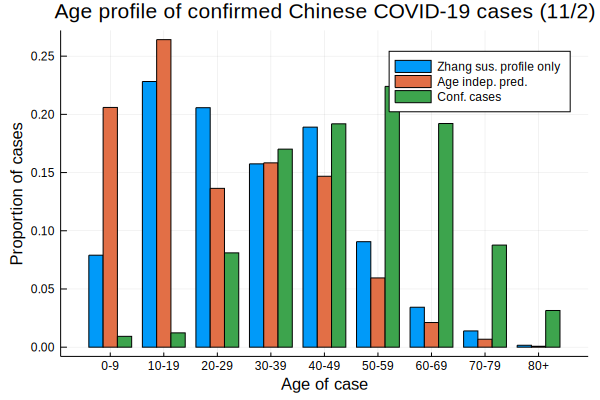

In [10]:
zhang_sus_dist = pred_case_distribution_using_iter_K_model2(χ_zhang,ones(17),ones(17),China_to_from)
_zhang_sus_dist = convert_to_data_agegroups(zhang_sus_dist)
plt = groupedbar(hcat(_zhang_sus_dist,_v,Case_Dist),lab = ["Zhang sus. profile only" "Age indep. pred." "Conf. cases"],
        xticks=(1:9,["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80+"]),
        title = "Age profile of confirmed Chinese COVID-19 cases (11/2)",
        ylabel = "Proportion of cases",
        xlabel = "Age of case")

In [11]:
# @load "HMC_chains_for_model2.jld2" d_chain_model2_epsilon_0 d_chain_model2_epsilon_01 d_chain_model2_epsilon_025 d_chain_model2_epsilon_05 d_chain_model2_epsilon_1  
trans = as((θ = as(Array, asℝ₊, 17),)); #Posterior draws are saved in transformed state, trans is used to convert back to untransformed draws.

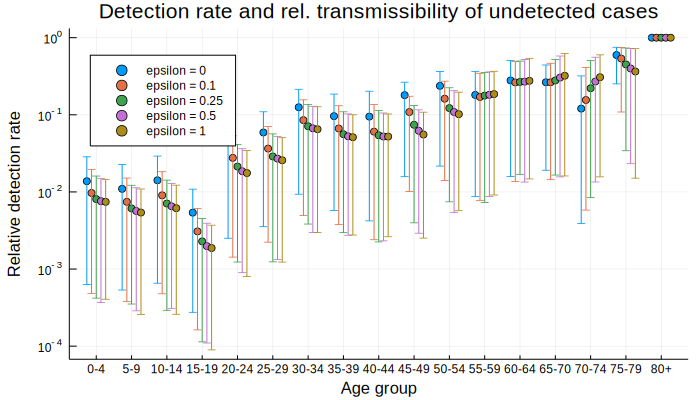

In [15]:
function MCMCchain2estimates(results)
    posterior = first.(transform.(trans, results.chain))
    posterior_array = zeros(length(posterior),17)
    for i = 1:length(posterior),j=1:17
        posterior_array[i,j] = posterior[i][j]
    end
    for i = 1:length(posterior),j=1:17
        posterior_array[i,j] = posterior_array[i,j]/posterior_array[i,17] #Renormalise d_80+ to 1 and other values to relative to this
    end    
    θ̂ = [mean(posterior_array[:,i]) for i = 1:17]
    lb = [quantile(posterior_array[:,i],0.025) for i = 1:17]
    ub = [quantile(posterior_array[:,i],0.975) for i = 1:17]
    return θ̂,θ̂ .- lb,ub.-θ̂
end

d_0,lb_0,ub_0 = MCMCchain2estimates(d_chain_model2_epsilon_0)
d_01,lb_01,ub_01 = MCMCchain2estimates(d_chain_model2_epsilon_01)
d_025,lb_025,ub_025 = MCMCchain2estimates(d_chain_model2_epsilon_025)
d_05,lb_05,ub_05 = MCMCchain2estimates(d_chain_model2_epsilon_05)
d_1,lb_1,ub_1 = MCMCchain2estimates(d_chain_model2_epsilon_1)


x = 5:30:(16*30+5)

fig_d = scatter(x.-8,d_0,yerr = (lb_0,ub_0),fillalpha = 0.3,lab="epsilon = 0",legend = :topleft,
    xticks = (x,["0-4","5-9","10-14","15-19","20-24","25-29","30-34","35-39","40-44","45-49","50-54","55-59","60-64","65-70","70-74","75-79","80+"]),
        ylabel = "Relative detection rate", title = "Detection rate and rel. transmissibility of undetected cases",
        yscale = :log10)
scatter!(fig_d,x.-4,d_01,yerr = (lb_01,ub_01),fillalpha = 0.3,lab="epsilon = 0.1")
scatter!(fig_d,x,d_025,yerr = (lb_025,ub_025),fillalpha = 0.3,lab="epsilon = 0.25")
scatter!(fig_d,x.+4,d_05,yerr = (lb_05,ub_05),fillalpha = 0.3,lab="epsilon = 0.5")
scatter!(fig_d,x.+8,d_1,yerr = (lb_1,ub_1),fillalpha = 0.3,lab="epsilon = 1")
scatter!(size=(700,400),xlabel = "Age group")
# savefig(fig_d,"model_2_detection_rates.png")
# @save "detection_rates_for_different_epsilons_model2.jld2" d_0 d_01 d_025 d_05 d_1


### Diagnostics for model 2

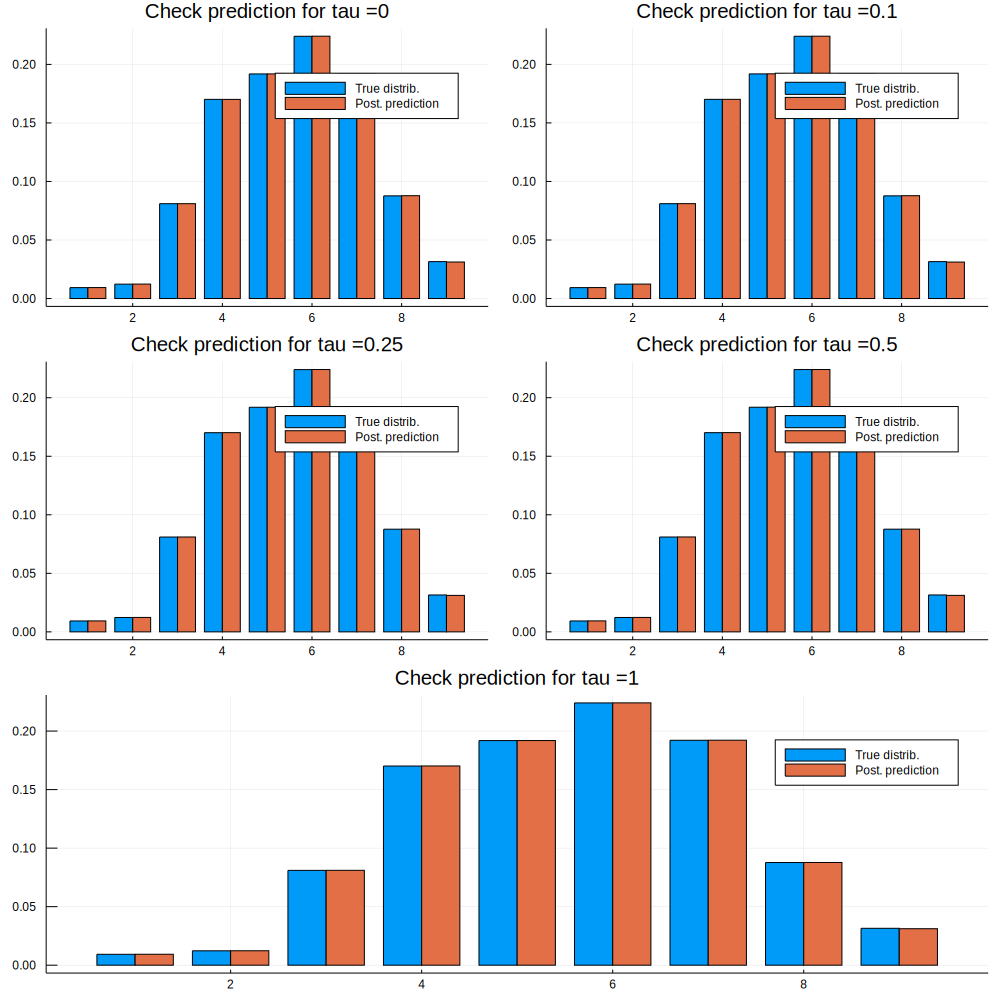

In [16]:
function posterior_prediction(result,tau)
    posterior = first.(transform.(trans, result.chain))
    pred = map(d -> pred_case_distribution_using_iter_K_model2(χ_zhang,d,tau*ones(17),China_to_from),posterior);
    _pred = map(convert_to_data_agegroups,pred)
    return groupedbar(hcat(Case_Dist,mean(_pred)),lab = ["True distrib." "Post. prediction"],title = "Check prediction for tau =$tau")
end
# plt_pred_05 = groupedbar(hcat(Case_Dist,mean(_pred)),lab = ["True distrib." "Post. prediction"],title = "Check prediction for tau =0.25")
plt1 = posterior_prediction(d_chain_model2_epsilon_0,0);
plt2 = posterior_prediction(d_chain_model2_epsilon_01,0.1);
plt3 = posterior_prediction(d_chain_model2_epsilon_025,0.25);
plt4 = posterior_prediction(d_chain_model2_epsilon_05,0.5);
plt5 = posterior_prediction(d_chain_model2_epsilon_1,1);

layout = @layout [a b;c d;e]
plt = plot(plt1,plt2,plt3,plt4,plt5,layout = layout)
plot!(plt,size = (1000,1000))


In [17]:
summarize_tree_statistics(d_chain_model2_epsilon_1.tree_statistics)

Hamiltonian Monte Carlo sample of length 10000
  acceptance rate mean: 0.9, 5/25/50/75/95%: 0.68 0.85 0.93 0.98 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 0%, 5 => 0%, 6 => 0%, 7 => 4%, 8 => 47%, 9 => 48%, 10 => 0%

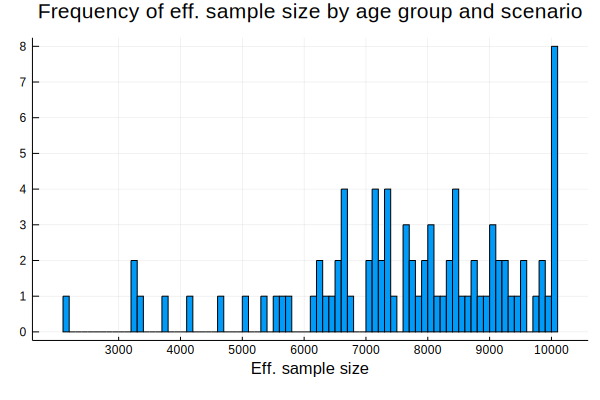

In [18]:
#Group results
results_group = [d_chain_model2_epsilon_0,d_chain_model2_epsilon_01,d_chain_model2_epsilon_025,d_chain_model2_epsilon_05,d_chain_model2_epsilon_1];
eff_sample_sizes = Float64[]
for result in results_group
    posterior = first.(transform.(trans, result.chain)) #Apply transformation to chain
    for a = 1:17 
        posterior_samples_for_group_a = [posterior[i][a] for i = 1:length(posterior)]
    push!(eff_sample_sizes,effective_sample_size(posterior_samples_for_group_a)   )
    end
end

histogram(eff_sample_sizes,bins = 100,lab = "",xlabel = "Eff. sample size",
            title = "Frequency of eff. sample size by age group and scenario",
            xticks = (3000:1000:10000),yticks = 0:1:15)